In [32]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as t

from torchsummary import summary

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.plotters import Plotter
from src.utils import *
from src.costs import InnerGW_opt, InnerGW_const
from src.models.resnet import resnet18_d, resnet18_g
from src.train import train


tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport",
                           entity="_devourer_",
                           mode="offline")

In [34]:
if torch.cuda.is_available():
    torch.cuda.set_device(2)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport",
                           entity="_devourer_",
                           mode="offline")

## Define source and target distributions

In [35]:
n_components = 10
locs = 2 * uniform_circle(n_components)
scales = .3 * torch.ones_like(locs)
source = GaussianMixture(locs, scales, device=DEVICE)

features, classes = load_mnist("../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
target = TensorDatasetDistribution(features, classes, device=DEVICE)
p, q = source.event_shape.numel(), target.event_shape.numel()

  0%|          | 0/60000 [00:00<?, ?it/s]

In [36]:
n_neurons = 128

critic = resnet18_d(target.event_shape).to(DEVICE)
summary(critic, target.event_shape, batch_size=512)

mover = resnet18_g(target.event_shape, q).to(DEVICE)
summary(mover, (q,), batch_size=512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 64, 16, 16]           3,136
       BatchNorm2d-2          [512, 64, 16, 16]             128
         LeakyReLU-3          [512, 64, 16, 16]               0
         MaxPool2d-4            [512, 64, 8, 8]               0
            Conv2d-5            [512, 64, 8, 8]          36,864
       BatchNorm2d-6            [512, 64, 8, 8]             128
         LeakyReLU-7            [512, 64, 8, 8]               0
            Conv2d-8            [512, 64, 8, 8]          36,864
       BatchNorm2d-9            [512, 64, 8, 8]             128
     EncoderBlock-10            [512, 64, 8, 8]               0
           Conv2d-11            [512, 64, 8, 8]          36,864
      BatchNorm2d-12            [512, 64, 8, 8]             128
        LeakyReLU-13            [512, 64, 8, 8]               0
           Conv2d-14            [512, 6

In [7]:
def run_experiment(source, target, cost, n_iter, *,
                   logger=None, **kwargs):
    if logger: logger.start()
    mover_copy = deepcopy(mover)
    critic_copy = deepcopy(critic)
    try:
        train(source, target, mover_copy, critic_copy, cost,
              n_iter=n_iter,
              logger=logger,
              **kwargs)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()
    return mover_copy, critic_copy

In [8]:
n_components = 7

locs =  fibonacci_sphere(n_components)
scales = .3 * torch.ones(n_components, p)
source = GaussianMixture(locs, scales)


locs = 2 * uniform_circle(n_components)
scales = 1 * torch.ones(n_components, q)
target = GaussianMixture(locs, scales)

In [ ]:
run_experiment(
    source, target,
    n_samples=512,
    n_iter=1000,
    cost=InnerGW(),
    logger=None,
    plot_interval=100
)

In [16]:
from src.plotters.matplotlib import *
from src.plotters.matplotlib import _get_projection, _get_component_centers

In [17]:
x, labels = source.sample((512,), return_labels=True)
y = target.sample((512,))
with torch.no_grad():
    h_x = mover(x)

In [18]:
from src.plotters.matplotlib import plot_transport


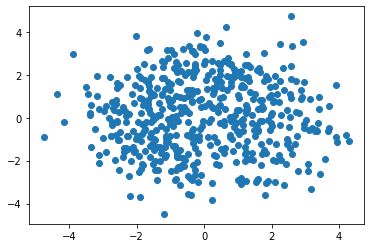

In [19]:
plt.scatter(*y.numpy().T)

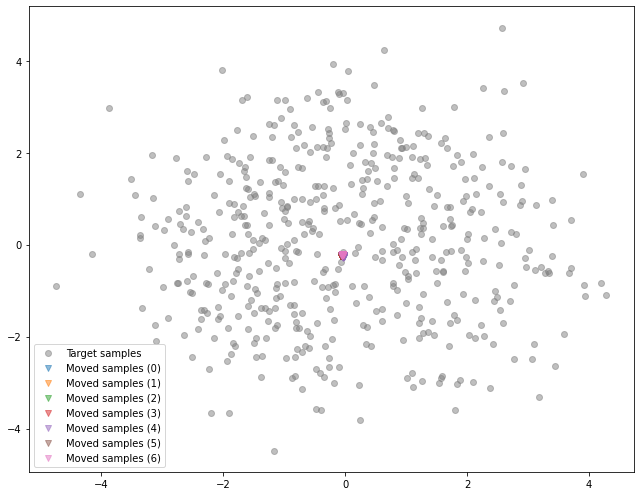

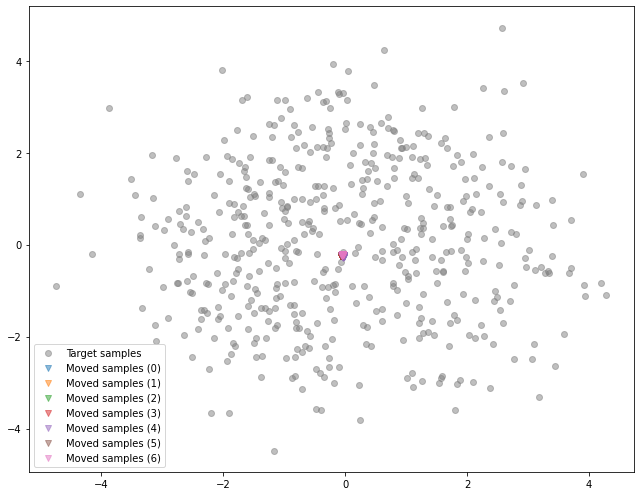

In [20]:
plot_transport(x, y, h_x, labels)